In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from modeling.models.bethge import BethgeModel
from modeling.train_utils import array_to_dataloader
from scipy.stats import spearmanr
from scripts.visualize_SharedCore import visualize_neuron
from scipy import optimize
import os

In [ ]:
def make_dir_try(dir):
    try:
        os.makedirs(dir, exist_ok=True)
        print("Directory '%s' created successfully" % dir)
    except OSError as error:
        print("Directory '%s' can not be created" % dir)

In [ ]:
site = 'm2s1'
nb_validation_samples = 1000
nb_training_samples = 49000

batch_size = 2048

train_y = np.load('A:/school/research/CNN_Tang_project/data/Processed_Tang_data/all_sites_data_prepared/New_response_data/trainRsp_'+site+'.npy')
num_neurons = train_y.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

channels = 256
num_layers = 9
input_size = 50
output_size = num_neurons
first_k = 9
later_k = 3
pool_size = 2
factorized = True

num_maps = 1

net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                  output_size=output_size, first_k=first_k, later_k=later_k,
                  input_channels=1, pool_size=pool_size, factorized=True,
                  num_maps=num_maps).cuda()

net.to(device)
net.load_state_dict(torch.load('D:/school/research/CNN_Tang_project/saved_models/new_learned_models/m2s1_9_model_version_0'))

fc_layer = net.fc[0].bank[0]

In [3]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [4]:
feature_w = fc_layer.weight_feature.data
spatial_w = fc_layer.weight_spatial.data
spatial_w_np = spatial_w.detach().cpu().numpy()

In [50]:
for i, w in enumerate(spatial_w):
    w[:8,:] = 0
    w[:,13:] = 0
    w[13:,:] = 0
    w[:,:8] = 0
    spatial_w[i] = w

net.fc[0].bank[0].weight_spatial.data = spatial_w

In [15]:
#this time set center to 0
for i, w in enumerate(spatial_w):
    w[8:13,8:13]  = 0
    spatial_w[i] = w

net.fc[0].bank[0].weight_spatial.data = spatial_w

In [5]:
def make_dir_try(dir):
    try:
        os.makedirs(dir, exist_ok=True)
        print("Directory '%s' created successfully" % dir)
    except OSError as error:
        print("Directory '%s' can not be created" % dir)
site = 'm2s1'

In [40]:
directory_base = '/Graphs/no_center/'+site+'/'
#make_dir_try(directory_base)
all_width_x = []
all_width_y = []
for neuron in range(num_neurons):
    data = spatial_w_np[neuron]
    data = np.abs(cv2.resize(data, (50, 50)))
    # plt.figure(neuron)
    #
    # plt.matshow(data, cmap=plt.cm.gist_earth_r)

    params = fitgaussian(data)
    fit = gaussian(*params)

    ct_data = np.indices(data.shape)
    ct_z = fit(*ct_data)
    #levels = [0.2, 0.4, 0.6, 0.8, 1.0]
    # contour the gridded data, plotting dots at the randomly spaced data points.

    # plt.contour(ct_z,linewidths=0.5,colors='k')
    # #plt.contour(ct_z, cmap=plt.cm.copper)
    # ax = plt.gca()
    (height, x, y, width_x, width_y) = params
    all_width_x.append(width_x)
    all_width_y.append(width_y)
    # plt.text(0.95, 0.05, """
    # x : %.1f
    # y : %.1f
    # width_x : %.1f
    # width_y : %.1f""" %(x, y, width_x, width_y),
    #         fontsize=16, horizontalalignment='right',
    #         verticalalignment='bottom', transform=ax.transAxes)
    # directory = directory_base+str(neuron)+'.jpg'
    # plt.savefig(directory)

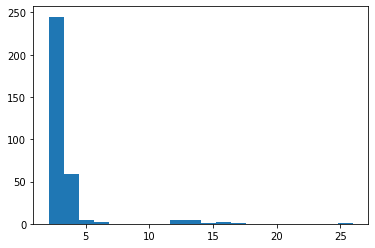

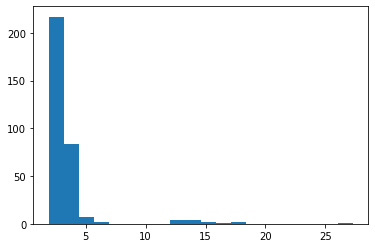

In [41]:
plt.figure()
plt.hist(all_width_x, bins=20)
plt.savefig('Graphs/std_receptive_size_histogram_x')
plt.figure()
plt.hist(all_width_y, bins=20)
plt.savefig('Graphs/std_receptive_size_histogram_y')

np.save('width_x_'+site,all_width_x)
np.save('width_y_'+site,all_width_y)

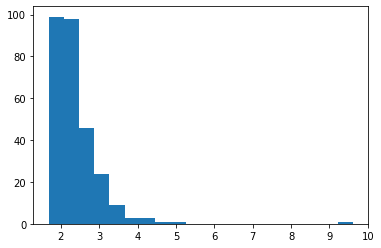

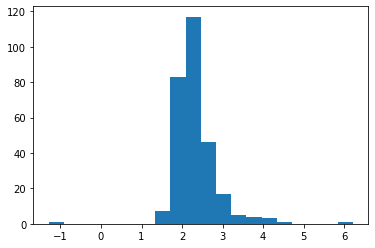

In [34]:
filtered_width_x = []
filtered_width_y = []
for x in all_width_x:
    if x < 10:
        filtered_width_x.append(x)
for y in all_width_y:
    if y < 10:
        filtered_width_y.append(y)
plt.figure()
plt.hist(filtered_width_x, bins=20)
plt.savefig('Graphs/std_receptive_size_histogram_x_filtered')
plt.figure()
plt.hist(filtered_width_y, bins=20)
plt.savefig('Graphs/std_receptive_size_histogram_y_filtered')

In [ ]:
site = 'm2s1'
directory_base = '../Graphs/spatial_weight_without_norm/'+site+'/'
make_dir_try(directory_base)
for neuron in range(num_neurons):
    data = spatial_w_np[neuron]
    plt.figure(neuron)

    plt.jet()
    plt.matshow(data)
    plt.colorbar()
    # params = fitgaussian(data)
    # fit = gaussian(*params)

    # ct_data = np.indices(data.shape)
    # ct_z = fit(*ct_data)
    # #levels = [0.2, 0.4, 0.6, 0.8, 1.0]
    # # contour the gridded data, plotting dots at the randomly spaced data points.
    # plt.contour(ct_z,linewidths=0.5,colors='k')
    # #plt.contour(ct_z, cmap=plt.cm.copper)
    # ax = plt.gca()
    # (height, x, y, width_x, width_y) = params
    #
    # plt.text(0.95, 0.05, """
    # x : %.1f
    # y : %.1f
    # width_x : %.1f
    # width_y : %.1f""" %(x, y, width_x, width_y),
    #         fontsize=16, horizontalalignment='right',
    #         verticalalignment='bottom', transform=ax.transAxes)
    directory = directory_base+str(neuron)+'.jpg'
    plt.savefig(directory)

In [ ]:
nb_validation_samples = 1000
nb_training_samples = 49000
train_x = np.load('../data/Processed_Tang_data/all_sites_data_prepared/pics_data/train_img_m2s1.npy')
val_x = np.load('../data/Processed_Tang_data/all_sites_data_prepared/pics_data/val_img_m2s1.npy')
train_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/trainRsp_m2s1.npy')
val_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/valRsp_m2s1.npy')
train_x =  np.transpose(train_x, (0, 3, 1, 2))
val_x =  np.transpose(val_x, (0, 3, 1, 2))
batch_size = 2048
num_neurons = 299

val_loader = array_to_dataloader(val_x, val_y, batch_size=200)
train_loader = array_to_dataloader(train_x, train_y, batch_size=200)

selected_idx = np.load('../data/tmp_data/selected_idx_R.npy')[:10]

with torch.no_grad():
    net.eval()
    prediction = []
    actual = []
    for batch_num, (x, y) in enumerate(tqdm(val_loader)):
        x, y = x.to(device), y.to(device)
        outputs = net(x).cpu().numpy()
        prediction.extend(outputs)
        actual.extend(y.cpu().numpy())

    prediction = np.stack(prediction)
    actual = np.stack(actual)
    R = np.zeros(299)
    VE = np.zeros(299)
    SR = np.zeros(299)
    MAE = np.zeros(299)
    for neuron in (range(num_neurons)):
        # vis_img = plt.imread("corr+mae/" + str(neuron) + '.jpg')
        # vis_img = torch.reshape(torch.tensor(vis_img).type(torch.FloatTensor), (1, 1, 50, 50)).to(device)
        # vis_img -= vis_img.min()
        # vis_img /= (vis_img.max() - vis_img.min())
        # vis_rsp = net(vis_img).cpu().numpy()


        pred1 = prediction[:, neuron]
        val_y = actual[:, neuron]
        mae = np.sum(np.abs(pred1 - val_y))
        MAE[neuron] = mae
        y_arg = np.argsort(val_y)

        u2 = np.zeros((2, nb_validation_samples))
        u2[0, :] = np.reshape(pred1, (nb_validation_samples))
        u2[1, :] = np.reshape(val_y, (nb_validation_samples))

        c2 = np.corrcoef(u2)
        R[neuron] = c2[0, 1]
        SR[neuron] = spearmanr(pred1, val_y)[0]
        VE[neuron] = 1 - np.var(pred1 - val_y) / np.var(val_y)

        fig = plt.figure(neuron)
        plt.plot(pred1[y_arg], label='pred')
        plt.plot(np.sort(val_y), label='actual')
        #plt.axhline(y=vis_rsp[:,neuron].item(), color='r', linestyle='-')
        plt.title(str(R[neuron]))
        plt.legend()
        directory = 'A:/school/College_Junior/research/CNN_Tang_project/Graphs/tests/pure_mae_tuning_'+str(channels)+'_'+str(num_layers)
        make_dir_try(directory)
        plt.savefig(directory+'/' + str(neuron) )
        plt.show()
        plt.close(fig)

    #selected_idx_SR = np.argsort(SR)[::-1]
    #np.save('selected_idx_SR', selected_idx_SR)
    #print(R)
    print(np.mean(SR))
    print(np.mean(R))
    print(np.mean(VE))
    print(np.mean(MAE))

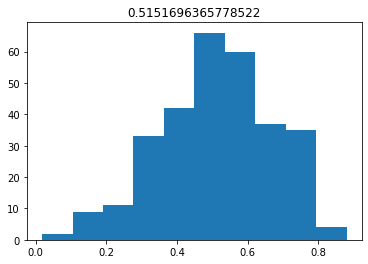

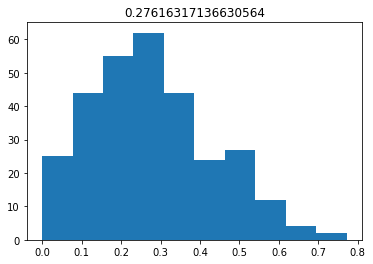

In [20]:
directory = 'A:/school/College_Junior/research/CNN_Tang_project/Graphs/tests/pure_mae_tuning_'+str(channels)+'_'+str(num_layers)
plt.hist(R)
plt.title(str(np.mean(R)))
plt.savefig(directory+'/Ro')
plt.show()
plt.hist(VE)
plt.title(str(np.mean(VE)))
plt.savefig(directory+'/VEo')
plt.show()

In [ ]:
def make_dir_try(dir):
    try:
        os.makedirs(dir, exist_ok=True)
        print("Directory '%s' created successfully" % dir)
    except OSError as error:
        print("Directory '%s' can not be created" % dir)
directory = 'A:/school/College_Junior/research/CNN_Tang_project/analysis/Visualization/corr_mae_trained'
make_dir_try(directory)

top_idx = np.argsort(R)
selected_idx = top_idx[::-1][:20]
for neuron in range(299):
    visualize_neuron(neuron, input_size, [net], directory, save=True)

In [52]:
a=np.zeros((50,50))
bar_wid=1
bar_len = 1
rsp_matrix = np.zeros((num_neurons,50,50))
for i in tqdm(range(a.shape[0])):
    for j in range(a.shape[0]):
        #plt.pause(0.1)
        a[i, max(0,j-2):min(50,j+2)]=1
        #plt.imshow(a)
        input = torch.FloatTensor(np.reshape(a,(1,1,50,50))).to(device)
        rspa=net(input).detach().cpu().numpy()
        a=np.zeros((50,50))
        a[max(0,i-2):min(50,i+2),j]=1
        #plt.imshow(a)
        input = torch.FloatTensor(np.reshape(a,(1,1,50,50))).to(device)
        rspb=net(input).detach().cpu().numpy()
        a=np.zeros((50,50))
        for neuron in range(num_neurons):
            rsp_matrix[neuron,i,j] = max(rspa[:,neuron],rspb[:,neuron])

100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


In [ ]:
for neuron in range(num_neurons):
    plt.pause(0.1)
    plt.imshow(rsp_matrix[neuron])
    plt.jet()

In [ ]:

site = 'm2s1'
directory_base = '../Graphs/receptive_test_focus/'+site+'/'
make_dir_try(directory_base)
for neuron in range(num_neurons):
    # Create the gaussian data
    Xin, Yin = np.mgrid[0:201, 0:201]
    #data = gaussian(3, 100, 100, 20, 40)(Xin, Yin) + np.random.random(Xin.shape)
    data = rsp_matrix[neuron]
    data -= data.min()
    data /= (data.max() - data.min())
    img = data * 256
    plt.figure(neuron)
    plt.matshow(data, cmap=plt.cm.gist_earth_r)

    params = fitgaussian(data)
    fit = gaussian(*params)

    ct_data = np.indices(data.shape)
    ct_z = fit(*ct_data)
    levels = [0.2, 0.4, 0.6, 0.8, 1.0]
    # contour the gridded data, plotting dots at the randomly spaced data points.
    plt.contour(ct_z,len(levels),linewidths=0.5,colors='k', levels=levels)
    #plt.contour(ct_z, cmap=plt.cm.copper)
    ax = plt.gca()
    (height, x, y, width_x, width_y) = params

    plt.text(0.95, 0.05, """
    x : %.1f
    y : %.1f
    width_x : %.1f
    width_y : %.1f""" %(x, y, width_x, width_y),
            fontsize=16, horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes)
    directory = directory_base+str(neuron)+'.jpg'
    plt.savefig(directory)